In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Conv1D, MaxPooling1D
from keras.optimizers import SGD, Adagrad, Adam
from keras.callbacks import EarlyStopping
import read
import numpy as np
import sklearn.metrics
from sklearn.model_selection import train_test_split
from keras.models import model_from_yaml
from keras import backend as K
print K.backend()
import tensorflow
from keras.callbacks import * 

Using TensorFlow backend.


tensorflow


In [2]:
def keras_model():

    model = Sequential()
    
    #model.add(Reshape((n, 4), input_shape=(n*4,)))
    
    model.add(Conv1D(32, 20, padding="same", input_shape=(n, 4,)))
    print model.input_shape
    print model.output_shape
    model.add(Activation('relu'))
    print model.output_shape
    model.add(MaxPooling1D(padding="same", strides=None, pool_size=200))

    # after Max Pooling
    print model.output_shape

    model.add(Flatten())
    print model.output_shape
    model.add(Dense(512))

    # Flattened 
    print model.output_shape

    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    # Finally
    print model.output_shape

    model.add(Activation('sigmoid'))
    return model

In [3]:
# using the abstract base class Callback to monitor test auPRC at each epoch. 
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        probas = self.model.predict_on_batch(x)
        auprc = sklearn.metrics.average_precision_score(y, probas)
        #loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTest auprc: {}\n'.format(auprc))


In [5]:
def train_and_test(X_train, y_train, X_test, y_test, n):

    model = keras_model()
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
    hist = model.fit(X_train, y_train, validation_split=0.1, callbacks=[early_stopping, TestCallback((X_test_rs,y_test))], batch_size= 200, nb_epoch= 8)
    #hist = model.fit(X_train, y_train, validation_split=0.1, batch_size= 200, shuffle = False, nb_epoch= 10)
    print hist.history
    probas = model.predict_on_batch(X_test_rs)
    print sklearn.metrics.average_precision_score(y_test, probas)
    np.savetxt("probas", probas)
    print "Done"
    return model, probas

In [10]:
n = 200
X,y = read.get_matrix("twoclass.rev.txt")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print "Done"

Done


In [11]:
K.image_data_format()
X_train_rs = np.reshape(X_train, (-1,200,4))
X_test_rs = np.reshape(X_test, (-1,200,4))

In [12]:
print X_train
print y_train

print "Start"
model, probas = train_and_test(X_train_rs, y_train, X_test, y_test, n)
print "Done"

[[0 0 1 ..., 0 1 0]
 [0 1 0 ..., 0 0 1]
 [0 0 1 ..., 0 1 0]
 ..., 
 [0 0 1 ..., 0 0 0]
 [0 0 1 ..., 0 1 0]
 [0 1 0 ..., 0 0 0]]
[0 1 0 ..., 0 0 1]
Start
(None, 200, 4)
(None, 200, 32)
(None, 200, 32)
(None, 1, 32)
(None, 32)
(None, 512)
(None, 1)
Train on 22304 samples, validate on 2479 samples
Epoch 1/8
22200/22304 [============================>.] - ETA: 0s - loss: 0.6865 - acc: 0.5535
Test auprc: 0.593064483615

22304/22304 [==============================] - 3s - loss: 0.6865 - acc: 0.5534 - val_loss: 0.6853 - val_acc: 0.5486
Epoch 2/8
22000/22304 [============================>.] - ETA: 0s - loss: 0.6774 - acc: 0.5658
Test auprc: 0.751912012357

22304/22304 [==============================] - 3s - loss: 0.6772 - acc: 0.5657 - val_loss: 0.6641 - val_acc: 0.5502
Epoch 3/8
22200/22304 [============================>.] - ETA: 0s - loss: 0.5977 - acc: 0.7135
Test auprc: 0.895250437374

22304/22304 [==============================] - 3s - loss: 0.5971 - acc: 0.7143 - val_loss: 0.4665 - val_ac

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# compute area under the roc curve
roc_auc = sklearn.metrics.roc_auc_score(y_test, probas)
print roc_auc

# compute the roc curve
fpr, tpr, thresholds = roc_curve(y_test, probas, pos_label=1)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.title("ROC curve")
plt.xlabel("True Positive Rate")
plt.ylabel("False Postive Rate")
plt.savefig("ROC Curve")

0.971114162658


In [14]:
# Trained
print "Trained miodel"
print model
print model.layers[-1].get_config()

Trained miodel
{'activation': 'sigmoid', 'trainable': True, 'name': 'activation_6'}


In [15]:
## Using the fucntional API. This method returns a function to find saliency given input and learning phase. 
def compile_saliency_function(model):
    
    inp = model.layers[0].input
    outp = model.layers[-1].output
    print inp
    print outp
    max_output = K.max(outp, axis=1)
    print max_output
    saliency = K.gradients(K.sum(max_output), inp)[0]
    print saliency
    return K.function([inp, K.learning_phase()], [saliency])

In [16]:
## saliency_fn on the given model. 
saliency_fn = compile_saliency_function(model)

Tensor("conv1d_2_input:0", shape=(?, 200, 4), dtype=float32)
Tensor("activation_6/Sigmoid:0", shape=(?, 1), dtype=float32)
Tensor("Max:0", shape=(?,), dtype=float32)
Tensor("gradients_2/conv1d_2/convolution/ExpandDims_grad/Reshape:0", shape=(?, 200, 4), dtype=float32)


In [19]:
print probas
print probas.shape
print X_test_rs.shape
print y_test.shape
print y_test
confidence= np.ravel(np.argsort(probas, axis = 0)[::-1])
probas_sorted = probas[confidence]


top = X_test_rs[confidence[:1500],:,:]
topy = y_test[confidence[:1500]]
top_probs = probas[confidence[:1500]]

bottom  = X_test_rs[confidence[2054:],:,:]
bottomy = y_test[confidence[2054:]]
bottom_probs = probas[confidence[2054:]]

[[ 0.84333718]
 [ 0.00560895]
 [ 0.01322296]
 ..., 
 [ 0.76491708]
 [ 0.94561613]
 [ 0.07547823]]
(2754, 1)
(2754, 200, 4)
(2754,)
[1 0 0 ..., 0 0 0]


In [18]:
## grad * input

# Top are Ngn2 # Reverse Coded, Top should be Ngn2
# Bottom are Ascl1

confidence= np.ravel(np.argsort(probas, axis = 0)[::-1])
print confidence
top = X_test_rs[confidence[:100],:,:]
print top.shape
print X_test_rs[:100].shape

[1291 1395 1866 ..., 2656  852  362]
(100, 200, 4)
(100, 200, 4)


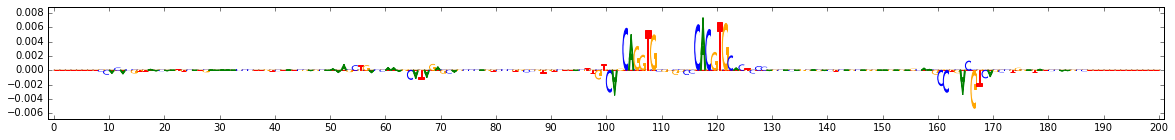

In [25]:
%matplotlib inline
idx = 100# Index we want to observe

# Ngn2 is coded as 1. So top probs are predicting Ngn2.
#print top[idx]
#print top_probs[idx]

#print probas
arr_sal = saliency_fn([top, 0])
outp = (np.asarray(arr_sal))[0][idx]
grad_star_inp = outp * top[idx]

#change encoding order to match deeplift viz
#print grad_star_inp

dl_scores = np.transpose(np.vstack((grad_star_inp[:][:,0],grad_star_inp[:][:,3],grad_star_inp[:][:,2],
                              grad_star_inp[:][:,1])))
from deeplift.visualization import viz_sequence
viz_sequence.plot_weights(dl_scores, subticks_frequency=10)

In [23]:
## Interpreting Fitlers.
W,b = model.layers[0].get_weights()
print W.shape
print b.shape

# dim1 = filter length
# dim2 = A,T,G,C
# dim3 = filter number


def get_filter(nb, W):
    A = list()
    T = list()
    G = list()
    C = list()
    for position in range(20):
        A.append(W[position][0][nb])
        T.append(W[position][1][nb])
        G.append(W[position][2][nb])
        C.append(W[position][3][nb])
        filter_cnn = np.vstack((A,T,G,C))
        # So these are the weights of the 4 channels for the first filter
        np.savetxt("filter" + str(nb), filter_cnn)

for i in range(32):
    get_filter(i,W)

(20, 4, 32)
(32,)


In [ ]:
# Serialising model to yaml
yamlstr = model.to_yaml()

In [26]:
# Saving model as yaml file. (Switch to json. Was using yaml for deeplift compatibility but that doesn't work 
# for me yet anyway. )
with open("CTCF_model.yaml", "w") as yaml_file:
    yaml_file.write(yamlstr)
print "Done"

Done
